# Document Scanner with OpenCv

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

#### Why convert BRG and RGB in openCV?

OpenCV uses BGR image format, so when we read an image using cv2.imread()
it interprets in BGR format by default.
We can use cvtColor() method to convert a BGR image to RGB and vice-versa.

Converting a BGR image to RGB and vice versa can have several reasons, one of them being that several image processing libraries have different pixel orderings. 

[https://www.geeksforgeeks.org/convert-bgr-and-rgb-with-python-opencv/]

In [214]:
img_path = "./images/01.jpg"

# Read image from path
img = cv2.imread(img_path)

# Resizing image with the .resize() method
img = cv2.resize(img, (1000,2000))


### Process of using the image for code processing
 
- remove the noise
- edge detection
- contour extraction
- best contour selection
- output

### Removte the noise

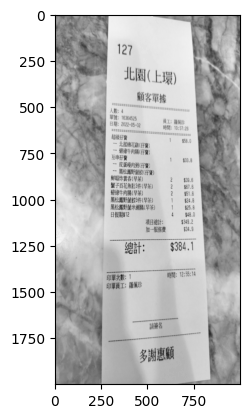

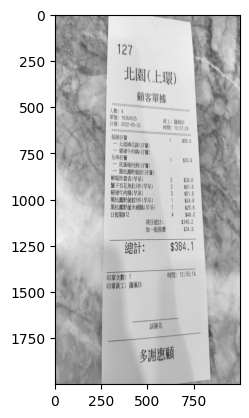

In [215]:
# Remove the noise --------------------------------------------------------------------
original = img.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) # making the image one color

# Blurring the image
blurred = cv2.GaussianBlur(gray, (5,5), 0) #GaussianBlur(src,ksize,sigmaX[,dst[,sigmaY[,borderType]]])


plt.imshow(blurred, cmap='gray')
plt.show()

plt.imshow(gray, cmap='gray')
plt.show()

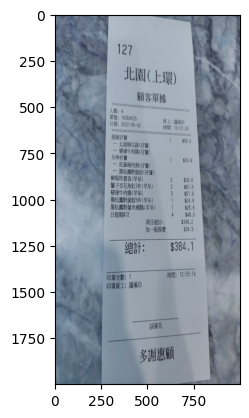

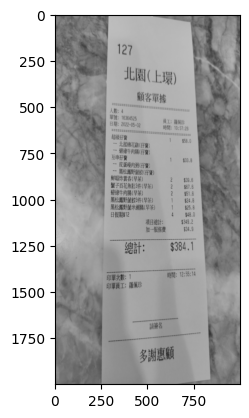

In [216]:
regen = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)


plt.imshow(original)
plt.show()

plt.imshow(regen)
plt.show()


### Edge Detection

#### Canny Edge Detection

Is a popular edge detection algorithm. It was developed by John F. Canny. The main caracteristics of this
algorithm are that:

1- It is a multi-stage algorithm and we will go through each stages.
Noise Reduction

2- Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a 5x5 Gaussian filter. We have already seen this in previous chapters.

3- Finding Intensity Gradient of the Image

Smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction $(G_x)$ and vertical direction $(G_y)$. 

From these two images, we can find edge gradient and direction for each pixel as follows:

$$
Edge\_Gradient \; (G) = \sqrt{G_x^2 + G_y^2}
$$
$$
Angle \; (\theta) = \tan^{-1} \bigg(\frac{G_y}{G_x}\bigg)
$$

[https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html]

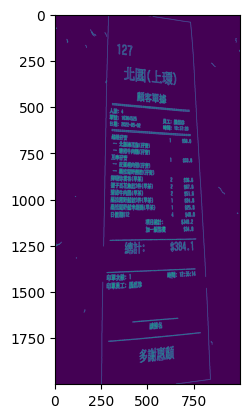

In [217]:
## Edge detection with Canny Edge algorithm
edges = cv2.Canny(gray, 50, 150)
original_edge = edges.copy()

plt.imshow(original_edge)
plt.show()

### Contour Extraction

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

tips:

- For better accuracy, use binary images. So before finding contours, apply threshold or canny edge detection.
- Since OpenCV 3.2, findContours() no longer modifies the source image.
- In OpenCV, finding contours is like finding white object from black background. So remember, object to be found should be white and background should be black.

[https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html]

#### Contours Hierarchy
Normally we use the cv.findContours() function to detect objects in an image, right ? Sometimes objects are in different locations. But in some cases, some shapes are inside other shapes. Just like nested figures. In this case, we call outer one as parent and inner one as child. This way, contours in an image has some relationship to each other. And we can specify how one contour is connected to each other, like, is it child of some other contour, or is it a parent etc. Representation of this relationship is called the Hierarchy.

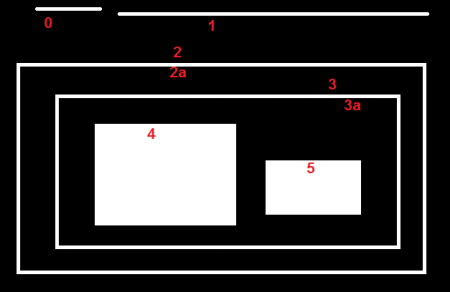

In this image, there are a few shapes which I have numbered from 0-5. 2 and 2a denotes the external and internal contours of the outermost box.

Here, contours 0,1,2 are external or outermost. We can say, they are in hierarchy-0 or simply they are in same hierarchy level.

Next comes contour-2a. It can be considered as a child of contour-2 (or in opposite way, contour-2 is parent of contour-2a). So let it be in hierarchy-1. Similarly contour-3 is child of contour-2 and it comes in next hierarchy. Finally contours 4,5 are the children of contour-3a, and they come in the last hierarchy level. From the way I numbered the boxes, I would say contour-4 is the first child of contour-3a (It can be contour-5 also).

[https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html]

In [218]:
# Contour extraction
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and find the largest contour
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = None

x, y, w, h = cv2.boundingRect(largest_contour)

In [219]:
for c in contours:
    p = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * p, True)
    
    if len(approx) == 4:
        largest_contour = approx
        break

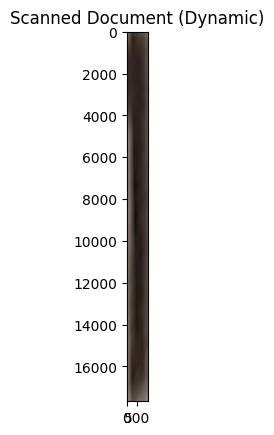

In [220]:
if largest_contour is not None:
    # Reorder the contour points
    def reorder(h):
        h = h.reshape((4, 2))
        hnew = np.zeros((4, 2), dtype=np.float32)
        
        add = h.sum(axis=1)
        hnew[0] = h[np.argmin(add)]
        hnew[2] = h[np.argmax(add)]
        
        diff = np.diff(h, axis=1)
        hnew[1] = h[np.argmin(diff)]
        hnew[3] = h[np.argmax(diff)]
        
        return hnew

    input_points = reorder(largest_contour)

    # Define output points based on input points and desired output size
    output_width = 1000  # Adjust the output width as needed
    output_height = int((input_points[2][1] - input_points[0][1]) * (output_width / (input_points[2][0] - input_points[0][0])))
    output_points = np.float32([[0, 0], [output_width, 0], [output_width, output_height], [0, output_height]])

    # Perform perspective transformation
    M = cv2.getPerspectiveTransform(input_points, output_points)
    warped_img = cv2.warpPerspective(img, M, (output_width, output_height))

    # Display the result
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.title('Scanned Document (Dynamic)')
    plt.show()
else:
    print("No suitable contour found.")

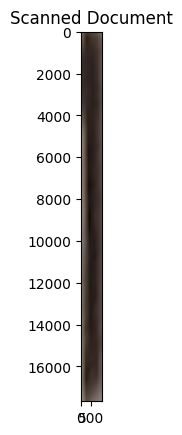

In [221]:
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.title('Scanned Document')
plt.show()